In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad, jacrev
from jax.lax import cond, scan
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, coords_2_strain_nn
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_hyperelasticity import NODE, init_layers, NODE_model_aniso, init_params_aniso, GOH_model, eval_Cauchy, eval_Cauchy_vmap, eval_P, eval_P_vmap
from utils_hyperelasticity import ThreeDElasticity
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

E_fun = vmap(lambda F: 0.5*(F.T@F - jnp.eye(2)))

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



## 1. Generate data + pretraining

In [2]:
params_stiff = jnp.stack([0.7,0.12,0.24,0.1,0.0])
params_soft  = jnp.stack([0.5,0.10,0.20,0.1,0.0])

def coords_2_params_gt(xy):
    x,y = xy
    t = 0.1
    params = cond(jnp.abs(x-0.5) > t,
                  lambda x: cond(jnp.abs(y-0.5)>t,
                                 lambda x: params_stiff,
                                 lambda x: params_soft,
                                 None),
                  lambda x: params_soft,
                  None)
    return params

In [3]:
GOH_P_vmap = vmap(ThreeDElasticity(GOH_model).ugrad_2_P, in_axes=(0, 0, None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: ThreeDElasticity(GOH_model).ugrad_2_P(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [4]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
F_hist_goh = []
P_hist_goh = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    params = vmap(coords_2_params_gt)(elem_X)
    params = np.expand_dims(params, 1)
    params_vec = jnp.repeat(params, axis=1, repeats=4)
    problem.set_params(params_vec)


    u = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(u), axis=1)
    F = u_grad + np.eye(2)

    P = GOH_P_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist_goh.append(F)
    P_hist_goh.append(P)
F_hist_goh = np.array(F_hist_goh)
P_hist_goh = np.array(P_hist_goh)

[02-02 00:01:55][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[02-02 00:01:55][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[02-02 00:01:55][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[02-02 00:01:56][DEBUG] jax_fem: Done pre-computations, took 0.34879589080810547 [s]
[02-02 00:01:56][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[02-02 00:01:56][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[02-02 00:01:56][DEBUG] jax_fem: Start timing
[02-02 00:01:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[02-02 00:01:57][DEBUG] jax_fem: Function split_and_compute_cell took 1.2929 seconds
[02-02 00:01:57][DEBUG] jax_fem: Creating sparse matrix with scipy...
[02-02 00:01:58][DEBUG] jax_fem: Linear guess solve...
[02-02 00:01:58][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[02-02 00:01:58][DEBUG] jax_fem: PETSc

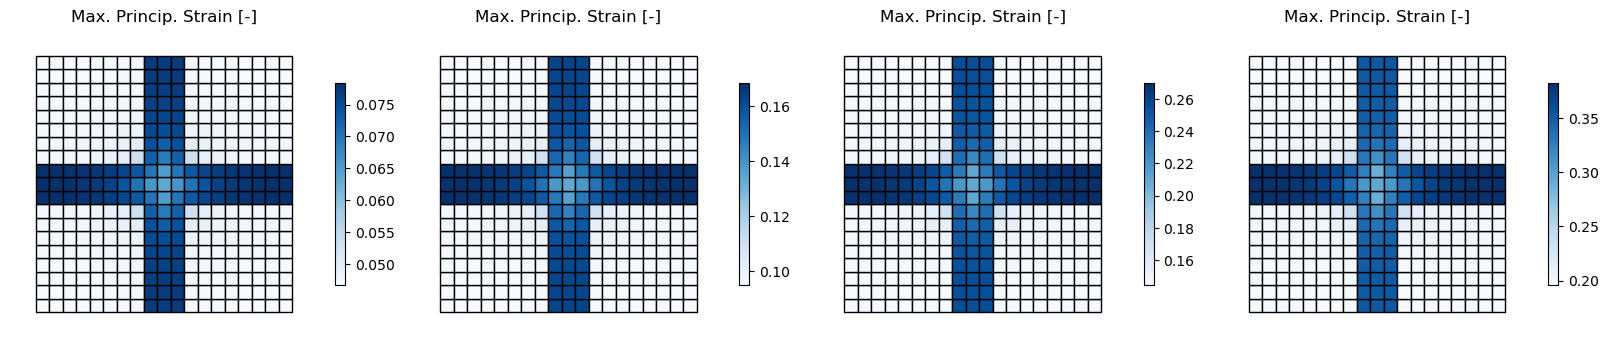

In [5]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, F, P, ax in zip(t_hist, F_hist_goh, P_hist_goh, axes):
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 

    strains.append(np.array([t*np.ones(len(F)), F[:,0,0], F[:,0,1], F[:,1,0], F[:,1,1]]))
strains = np.hstack(strains)

### Coords_2_strain NN

In [6]:
# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss_coords_2_strain(params, X, key):
    inp, out_gt = X[:,:3], X[:,3:] #inp: x,y,lmb and out_gt=eps_xx, eps_yy
    t = inp[:,2:3]
    out_pr = coords_2_strain_nn(inp, params)
    out_gt = out_gt/(t+1) #dividing by t+1 just for some regularization
    out_pr = out_pr/(t+1) #dividing by t+1 just for some regularization
    return jnp.mean((out_pr-out_gt)**2)

n_ff = 20 # 10 cosines and 10 sines in the fourier features
n_inp = 2 # x, y
ff_params = np.random.normal(size=n_inp*n_ff).reshape([n_inp,n_ff])*0.5
nn_layers = [2*n_ff+1,20,20,4]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params = [ff_params, nn_params]

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(coord_2_strain_params)

X = np.vstack([elem_X, elem_X, elem_X, elem_X])
inp = np.hstack([X, strains.T])
coord_2_strain_params, train_loss, _ = train(loss_coords_2_strain, inp, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=1000, batch_size=1000)

it 1000, train loss = 1.907262e-04
it 2000, train loss = 1.007064e-04
it 3000, train loss = 6.325410e-05
it 4000, train loss = 4.680853e-05
it 5000, train loss = 3.952871e-05
it 6000, train loss = 3.391249e-05
it 7000, train loss = 2.930305e-05
it 8000, train loss = 2.668476e-05
it 9000, train loss = 2.501449e-05
it 10000, train loss = 2.333298e-05
it 11000, train loss = 2.049791e-05
it 12000, train loss = 2.022915e-05
it 13000, train loss = 1.949941e-05
it 14000, train loss = 1.586892e-05
it 15000, train loss = 1.492718e-05
it 16000, train loss = 1.412502e-05
it 17000, train loss = 1.422233e-05
it 18000, train loss = 1.369749e-05
it 19000, train loss = 1.173495e-05
it 20000, train loss = 1.097604e-05
it 21000, train loss = 1.031588e-05
it 22000, train loss = 1.047954e-05
it 23000, train loss = 1.030407e-05
it 24000, train loss = 1.053630e-05
it 25000, train loss = 9.315032e-06
it 26000, train loss = 9.336349e-06
it 27000, train loss = 8.536325e-06
it 28000, train loss = 8.343464e-06
i

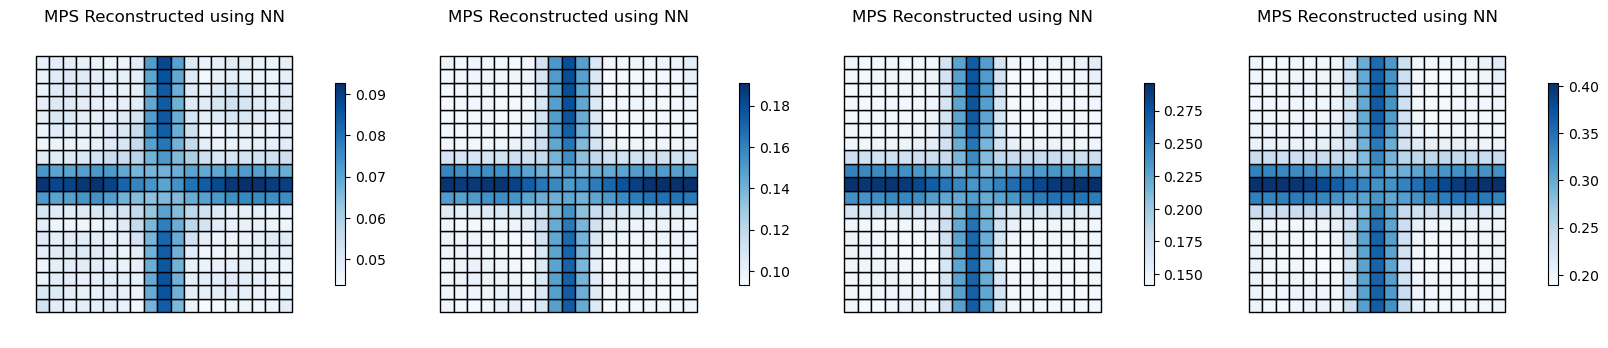

In [7]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
for t in t_hist:
    ax = axes[t]
    aux = np.hstack([elem_X, t*np.ones_like(elem_X[:,:1])])
    F_xx, F_xy, F_yx, F_yy = coords_2_strain_nn(aux, coord_2_strain_params).T
    F = np.stack([F_xx, F_xy, F_yx, F_yy]).T.reshape([-1,2,2])
    
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T
    mps = np.maximum(E_11, E_22)

    plotmesh(mesh.cells, mesh.points, mps, title='MPS Reconstructed using NN', ax=ax); 

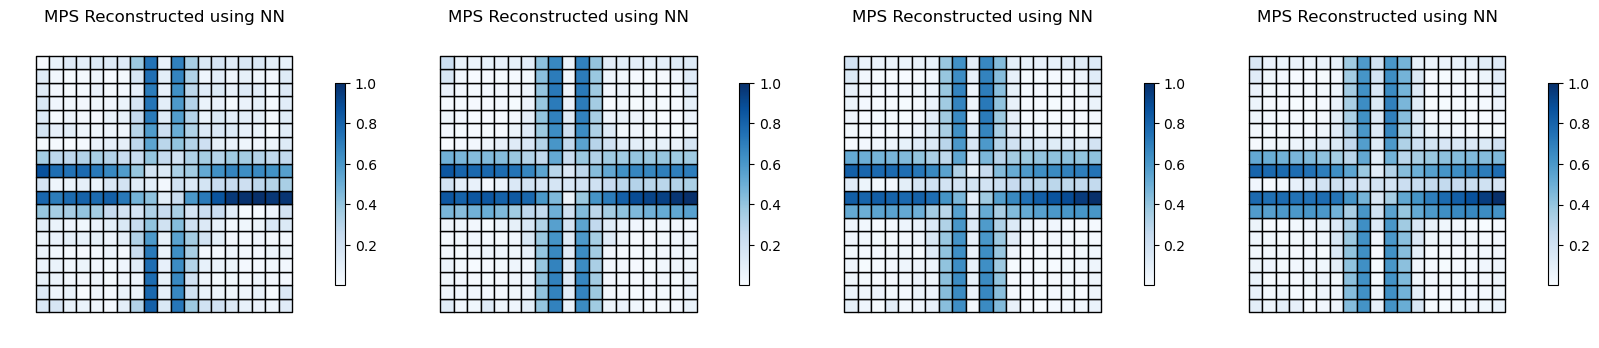

In [5]:
def get_mps(inp):
    F_xx, F_xy, F_yx, F_yy = coords_2_strain_nn(inp[None,:], coord_2_strain_params).T
    F = jnp.stack([F_xx, F_xy, F_yx, F_yy]).T.reshape([-1,2,2])
    
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T
    mps = jnp.maximum(E_11, E_22)
    return mps
def get_mean_dmps_dX(inp):
    dmps_dX = jnp.abs(jnp.squeeze(jacrev(get_mps)(inp))[:2])
    return jnp.mean(dmps_dX)
def get_mean_dmps_dX_norm(inp):
    out = vmap(get_mean_dmps_dX)(inp)
    return out/jnp.max(out)

fig, axes = plt.subplots(1,4,figsize=(20,4))
for t in t_hist:
    ax = axes[t]
    aux = np.hstack([elem_X, t*np.ones_like(elem_X[:,:1])])
    c = get_mean_dmps_dX_norm(aux)
    plotmesh(mesh.cells, mesh.points, c, title='MPS Reconstructed using NN', ax=ax); 

In [9]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(mesh.cells):
    if any([mesh.points[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([mesh.points[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([mesh.points[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([mesh.points[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

# get the reaction forces by integrating the stresses of the boundary elements
rgt_bd_frc = np.sum(P_hist_goh[:,rgt_bd_elems,0,0], axis=1)
lft_bd_frc = np.sum(P_hist_goh[:,lft_bd_elems,0,0], axis=1)
top_bd_frc = np.sum(P_hist_goh[:,top_bd_elems,1,1], axis=1)
bot_bd_frc = np.sum(P_hist_goh[:,bot_bd_elems,1,1], axis=1)
Force_x = jnp.array(0.5*(rgt_bd_frc + lft_bd_frc))
Force_y = jnp.array(0.5*(top_bd_frc + bot_bd_frc))

# get the center points of the elements
rgt_bd_X = elem_X[rgt_bd_elems]
top_bd_X = elem_X[top_bd_elems]
lft_bd_X = elem_X[lft_bd_elems]
bot_bd_X = elem_X[bot_bd_elems]
bd_X = rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X

In [10]:
# Homogenize the strains
F_xx_mean = np.mean(F_hist_goh[:,:,0,0], axis=1)
F_xy_mean = np.mean(F_hist_goh[:,:,0,1], axis=1)
F_yx_mean = np.mean(F_hist_goh[:,:,1,0], axis=1)
F_yy_mean = np.mean(F_hist_goh[:,:,1,1], axis=1)

P_xx_mean = Force_x/len(rgt_bd_elems)
P_yy_mean = Force_y/len(top_bd_elems)
inputs = np.array([F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, P_xx_mean, P_yy_mean]).T

n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_stress(params, x, key):
    model = NODE_model_aniso(params)
    F_xx, F_xy, F_yx, F_yy, P_xx_gt, P_yy_gt = x.T
    P = eval_P_vmap(F_xx, F_xy, F_yx, F_yy, model)
    P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
    return np.mean((P_xx_pr-P_xx_gt)**2+(P_yy_pr-P_yy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train(loss_stress, inputs, get_params, opt_update, opt_state, key, nIter = 20000, print_freq=1000)

it 1000, train loss = 9.152411e-02
it 2000, train loss = 5.627983e-02
it 3000, train loss = 3.383994e-02
it 4000, train loss = 2.379444e-02
it 5000, train loss = 1.248893e-02
it 6000, train loss = 4.536422e-05
it 7000, train loss = 3.960200e-05
it 8000, train loss = 3.557141e-05
it 9000, train loss = 2.143308e-05
it 10000, train loss = 1.008962e-05
it 11000, train loss = 6.500892e-06
it 12000, train loss = 6.089066e-06
it 13000, train loss = 5.936583e-06
it 14000, train loss = 5.812888e-06
it 15000, train loss = 5.754742e-06
it 16000, train loss = 5.717160e-06
it 17000, train loss = 5.676510e-06
it 18000, train loss = 5.631210e-06
it 19000, train loss = 5.584309e-06
it 20000, train loss = 5.539852e-06


In [11]:
mymodel = NODE_model_aniso(node_params)
P = eval_P_vmap(F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, mymodel)
P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
print('gt P_xx & P_yy: ', P_xx_mean, P_yy_mean)
print('pr P_xx & P_yy: ', P_xx_pr, P_yy_pr)

gt P_xx & P_yy:  [0.34852 0.63225 0.87102 1.07886] [0.33596 0.60411 0.82392 1.00894]
pr P_xx & P_yy:  [0.34719 0.6346  0.86918 1.0794 ] [0.33477 0.60645 0.82193 1.00956]


In [12]:
# Fit a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

# ff_params = coord_2_strain_params[0]
# ff_nn2 = lambda x, nn_params: ff_nn(x, [ff_params, nn_params])
def loss_Lambda(params, inp, key):
    out_pr = ff_nn(inp, params)
    return jnp.mean((out_pr-phi)**2)

n_ff = 10
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,40,40,n_phi]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 5000, print_freq=1000)

it 1000, train loss = 3.774067e-04
it 2000, train loss = 9.963244e-05
it 3000, train loss = 4.057106e-05
it 4000, train loss = 1.967377e-05
it 5000, train loss = 1.040639e-05


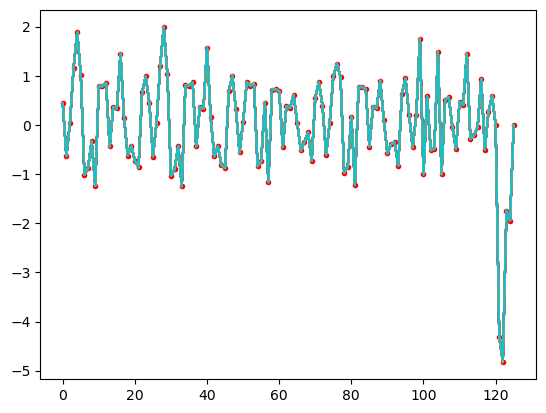

In [13]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = ff_nn(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [14]:
with open('params/cross_pre.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains,
                 bd_X, lmb_hist, P_hist_goh, F_hist_goh, t_hist], f)

## 2. Retrain

In [4]:
with open('params/cross_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains, \
                 bd_X, lmb_hist, P_hist_goh, F_hist_goh, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [6]:
@partial(jit, static_argnums=(1,))
def sample_points(key, batch_size):
    XY_colloc = random.uniform(key, (batch_size*10,2))
    t_colloc = random.choice(key, t_hist, (batch_size*10,1))
    XYt_colloc = jnp.hstack([XY_colloc, t_colloc])
    prob = get_mean_dmps_dX_norm(XYt_colloc)
    XYt_colloc = random.choice(key, XYt_colloc, p=prob, shape=(batch_size,))
    return XYt_colloc

@partial(jit, static_argnums=(0,2,3,))
def step_colloc(loss, i, get_params, opt_update, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch)
    return opt_update(i, g, opt_state)
    
def train_colloc(loss, inp, get_params, opt_update, opt_state, key, sharding, fname, nIter = 10000, print_freq=1000, metric_fns=None, batch_size=10000):
    node_X, t_hist = inp
    node_X_ext = jnp.hstack([node_X, t_hist[-1]*np.ones_like(node_X[:,:1])]) #append a row consisting of t_hist[-1]
    val_loss = []
    metrics = []
    for it in range(nIter):
        key, subkey = random.split(key)
        XYt_colloc = sample_points(key, batch_size)
        # X = [XYt_colloc, random.choice(key, t_hist)]
        opt_state = step_colloc(loss, it, get_params, opt_update, opt_state, XYt_colloc)
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            # with open('params/incr/'+fname+'_epoch_{}.npy'.format(it+1), 'wb') as f:
            #     pickle.dump(params, f)
            val_loss_value = loss(params, node_X_ext)
            val_loss.append(val_loss_value)
            if metric_fns is not None:
                m = []
                for metric_fn in metric_fns:
                    m.append(metric_fn(params, node_X_ext))
                metrics.append(m)
            to_print = "it {}, val loss = {:e}".format(it+1, val_loss_value)
            print(to_print)
    return get_params(opt_state), val_loss, metrics

In [7]:
# Train
a1 = 10000
@jit
def loss(Lambda_params, XYt_colloc):
    Div_x, Div_y = divergence(Lambda_params, XYt_colloc, coord_2_strain_params, NODE_w_unravel)
    loss_Div = a1*(Div_x**2 + Div_y**2)

    # def bd_forces_loss(_, t):
    #     F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, t, bd_X, coord_2_strain_params, NODE_w_unravel)
    #     Fx = Force_x[jnp.array(t, int)]
    #     Fy = Force_y[jnp.array(t, int)]
    #     return None, a2*((F_rgt-Fx)**2 + (F_top-Fy)**2 + (F_lft-Fx)**2 + (F_bot-Fy)**2)
    # loss_F = jnp.mean(scan(bd_forces_loss, init=None, xs=t_hist)[1])
    loss_F = 0.0
    
    return loss_Div + loss_F

lr = 1e-5
sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

node_X_ext = jnp.hstack([mesh.points, t_hist[-1]*np.ones_like(mesh.points[:,:1])])
metric1 = lambda params, X:  bd_forces(params, t_hist[-1], bd_X, coord_2_strain_params, NODE_w_unravel)
metric2 = lambda params, X: divergence(params, node_X_ext, coord_2_strain_params, NODE_w_unravel)

Lambda_params, val_loss, metrics = train_colloc(loss, [mesh.points, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, 'cross', nIter = 50000, print_freq=1000, batch_size=1000)

with open('params/cross_post.npy', 'wb') as f:
    pickle.dump([mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics], f)

it 1000, val loss = 3.863338e+00
it 2000, val loss = 1.431596e+00
it 3000, val loss = 7.257619e-01
it 4000, val loss = 4.703335e-01
it 5000, val loss = 3.385081e-01
it 6000, val loss = 2.540884e-01
it 7000, val loss = 2.051990e-01
it 8000, val loss = 1.715416e-01
it 9000, val loss = 1.294496e-01
it 10000, val loss = 1.071642e-01
it 11000, val loss = 8.704407e-02
it 12000, val loss = 6.873058e-02
it 13000, val loss = 3.273137e-02
it 14000, val loss = 3.689346e-02
it 15000, val loss = 4.526106e-02
it 16000, val loss = 4.070507e-02
it 17000, val loss = 2.351010e-02
it 18000, val loss = 3.013457e-02
it 19000, val loss = 4.017738e-02
it 20000, val loss = 3.604829e-02
it 21000, val loss = 4.372281e-02
it 22000, val loss = 3.419580e-02
it 23000, val loss = 5.359125e-02
it 24000, val loss = 6.152862e-02
it 25000, val loss = 6.112974e-02
it 26000, val loss = 5.620343e-02
it 27000, val loss = 9.468244e-02
it 28000, val loss = 7.475320e-02
it 29000, val loss = 1.019841e-01
it 30000, val loss = 1.

Some info about run times:
- Case 1: loss_F = 0.0, loss_Div is calculated, metric1 & metric2 are calculated, batch_size=10000 ---> the first 1000 epochs take 7 min exactly.
- Case 2: Same as Case 1 but I even included metrics, the results were still similar ---> The first 1000 epochs take 7 min 18 sec
- Case 3: Same as Case 2 except with batch_size=1000 ---> The first 1000 epochs take 2 min 20 sec, then less than 1 min per 1000 epochs

## 3. Test

In [8]:
with open('params/cross_post.npy', 'rb') as f:
    mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

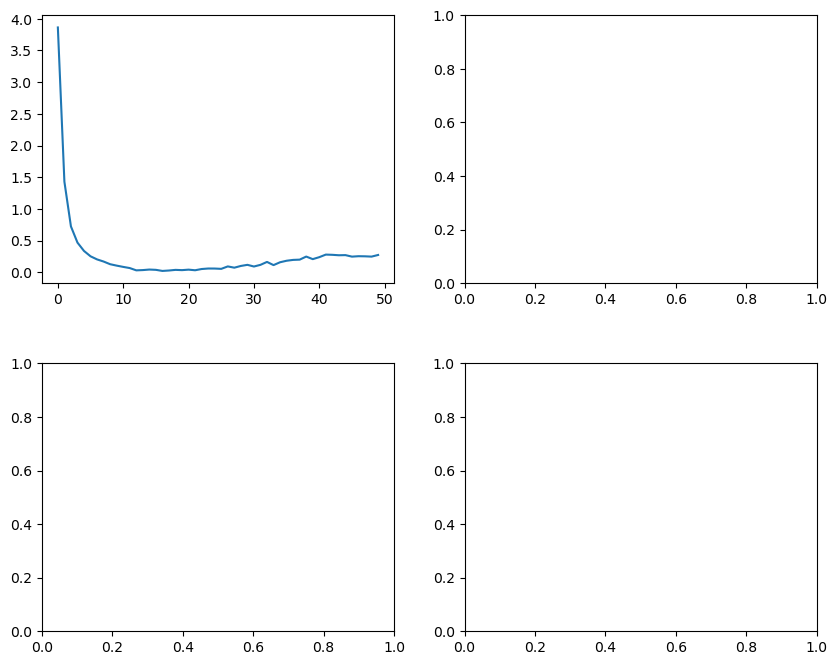

In [9]:
forces = []
div = []
for i in range(len(metrics)):
    forces.append(metrics[i][0])
    div.append(metrics[i][1])
forces = np.array(forces)
div = np.array(div)

fig, ax = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
ax[0,0].plot(val_loss)
ax[0,1].plot(div[:,0], label='Divergence in x')
ax[0,1].plot(div[:,1], label='Divergence in y')

ax[1,0].plot(forces[:,0], label='right')
ax[1,1].plot(forces[:,1], label='top')
ax[1,0].plot(forces[:,2], label='left')
ax[1,1].plot(forces[:,3], label='bottom')

ax[1,0].axhline(Force_x[-1], linestyle='--', label='Reaction force x')
ax[1,1].axhline(Force_y[-1], linestyle='--', label='Reaction force y')

# ax[0,0].set(yscale='log')
ax[0,0].set(title='Validation loss = ' + str(val_loss[-1]), yscale = 'log')
ax[0,1].set(title='Divergence')
ax[1,0].set(title='Forces on right & left')
ax[1,1].set(title='Forces on top & bottom')
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

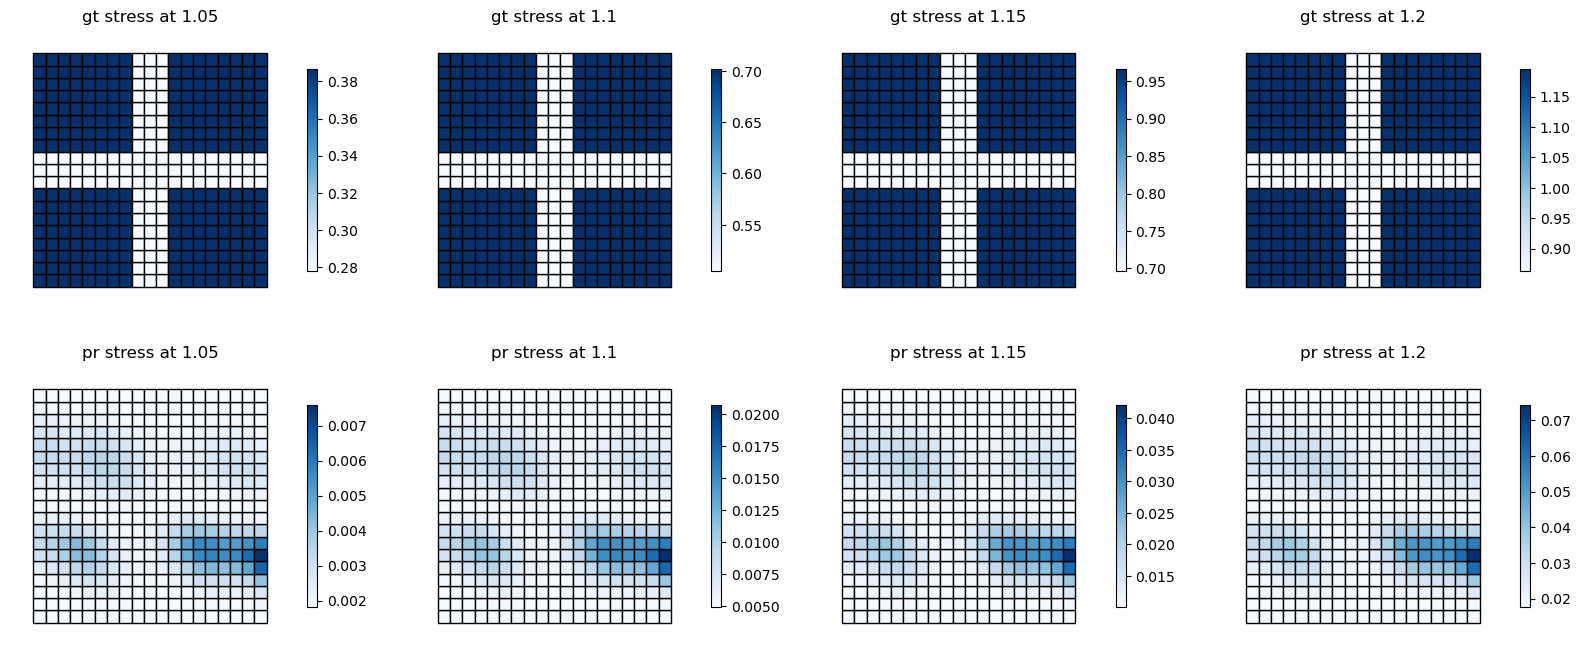

In [10]:
# Stiffness across the domain
fig, axes = plt.subplots(2,4,figsize=(20,8))
for lmb, ax in zip(lmb_hist, axes.T):
    ugrad = jnp.array([[lmb-1.0, 0.0], [0.0, lmb-1.0]])

    params_gt = vmap(coords_2_params_gt)(elem_X)
    params_pr = ff_nn(elem_X, Lambda_params)

    c_elem_gt = []
    c_elem_pr = []
    for params_gt_i, params_pr_i in zip(params_gt, params_pr):
        c_elem_gt.append(ThreeDElasticity(GOH_model).ugrad_2_P(ugrad, params_gt_i, 2)[0,0])
        c_elem_pr.append(ThreeDElasticity(NODE_w_unravel).ugrad_2_P(ugrad, params_pr_i, 2)[0,0])
    
    plotmesh(mesh.cells, mesh.points, c_elem_gt, title='gt stress at {}'.format(str(lmb)), ax=ax[0]); 
    plotmesh(mesh.cells, mesh.points, c_elem_pr, title='pr stress at {}'.format(str(lmb)), ax=ax[1]); 

In [4]:
P_vmap = vmap(ThreeDElasticity(NODE_w_unravel).ugrad_2_P, in_axes=(0, 0, None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: ThreeDElasticity(NODE_w_unravel).ugrad_2_P(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [5]:
params_vec = []
for x, y in elem_X:
    Lambda_inp = np.array([x,y]).reshape([-1,2])
    phi = ff_nn(Lambda_inp, Lambda_params).flatten()
    params_vec.append(phi)
params_vec = jnp.array(params_vec).reshape([len(params_vec),1,-1])
params_vec = jnp.repeat(params_vec, axis=1, repeats=4)

In [6]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
P_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    P = P_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    P_hist.append(P)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
P_hist = np.array(P_hist)

[01-29 12:02:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-29 12:02:18][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[01-29 12:02:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[01-29 12:02:19][DEBUG] jax_fem: Done pre-computations, took 0.3462047576904297 [s]
[01-29 12:02:19][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[01-29 12:02:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-29 12:02:19][DEBUG] jax_fem: Start timing
[01-29 12:02:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-29 12:02:22][DEBUG] jax_fem: Function split_and_compute_cell took 2.7130 seconds
[01-29 12:02:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-29 12:02:22][DEBUG] jax_fem: Linear guess solve...
[01-29 12:02:22][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[01-29 12:02:22][DEBUG] jax_fem: PETSc 

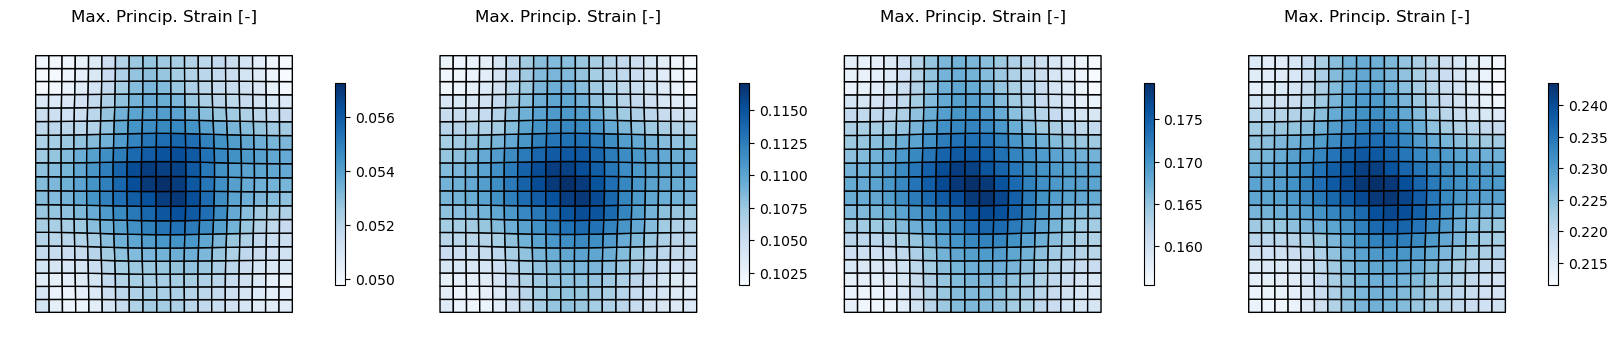

In [8]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, ax in zip(t_hist, node_x_hist, F_hist, axes):
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 